In [1]:
# Second attempt at 2022 Blue Rose take-home work

In [2]:
# Packages

import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim
from scipy.interpolate import make_interp_spline

from sklearn.metrics import jaccard_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split

In [3]:
# Notebook preferences

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

sunlight_cat = ["#156B90", "#9a3e25", "#708259","#bd8f22" ,"#842854","#ba5f06","#0f8c79","#bd2d28","#A0B700","#f2da57","#8e6c8a","#7abfcc", "#f3a126"]

sns.color_palette(sunlight_cat)

dict_rc = {"grid.color": "#635F5D",'axes.facecolor':"#efecea", 'figure.facecolor':"#efecea", 'axes.edgecolor': "#635F5D",

               'axes.labelcolor': "#635F5D", 'text.color': '#635F5D','xtick.color': '#635F5D','ytick.color': '#635F5D'};

sns.set_theme(context='notebook', palette = sunlight_cat, rc = dict_rc)

np.random.seed(3332)

In [4]:
# Import data

training_data = pd.read_csv('br_takehome_exam_2022_training.csv')
scoring_data = pd.read_csv('br_takehome_exam_2022_scoring.csv')

In [5]:
# Have a quick look at the basics

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   job_aptitude_exam   1000 non-null   float64
 1   same_industry       1000 non-null   int64  
 2   unexcused_absences  1000 non-null   int64  
 3   hs_gpa              980 non-null    float64
 4   job_offered         1000 non-null   int64  
 5   good_behavior       900 non-null    float64
 6   high_school         1000 non-null   int64  
 7   enrolled_late       1000 non-null   int64  
 8   instructor          950 non-null    object 
 9   sensitive_01        1000 non-null   float64
 10  sensitive_02        1000 non-null   float64
 11  sensitive_03        1000 non-null   float64
 12  sensitive_04        1000 non-null   float64
 13  sensitive_05        1000 non-null   int64  
 14  sensitive_06        1000 non-null   int64  
 15  sensitive_07        1000 non-null   float64
 16  sensiti

In [6]:
# Below are missing data, we should check to see if we need to do anything with them:
# hs_gpa, good_behavior, instructor, sensitive_10

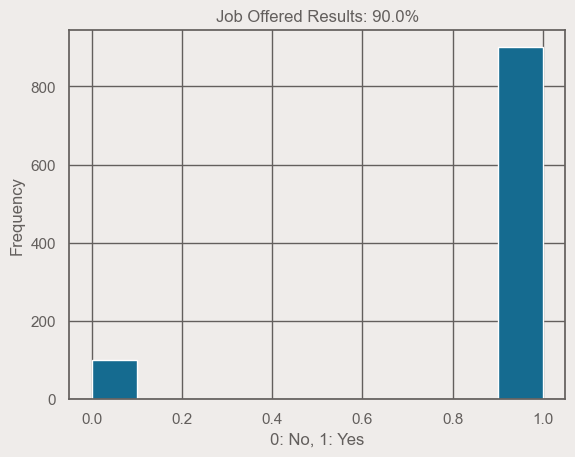

In [7]:
# Plot outcome

training_data.job_offered.plot.hist()
plt.xlabel('0: No, 1: Yes')
plt.title(f'Job Offered Results: {training_data.job_offered.value_counts()[1]/training_data.job_offered.value_counts()[0]*10}' + '%');

In [8]:
float_cols = ['job_aptitude_exam', 'hs_gpa', 'sensitive_01',
       'sensitive_02', 'sensitive_03', 'sensitive_04', 'sensitive_07',
       'sensitive_08', 'sensitive_09', 'sensitive_11',
       'sensitive_12', 'sensitive_13', 'sensitive_14', 'sensitive_19',
       'sensitive_23', 'sensitive_25','unexcused_absences'];

In [9]:
# Normalize the float data

normalized_float_training_data = (training_data[float_cols] - training_data[float_cols].min()) / (training_data[float_cols].max() - training_data[float_cols].min())

In [10]:
# Fit some quick regressions just to check for potential features

fit_list = [];
log_fit_list = [];
coef_list = [];
log_coef_list = [];
pointbiserial_list = [];

for col in float_cols:
    fit_list.append(LinearRegression().fit(normalized_float_training_data[f'{col}'].dropna().to_numpy().reshape(-1, 1),
                                           training_data.dropna(subset=f'{col}').job_offered.to_numpy()))
    log_fit_list.append(LogisticRegression(penalty='l1',solver='liblinear').fit(normalized_float_training_data[f'{col}'].dropna().to_numpy().reshape(-1, 1),
                                           training_data.dropna(subset=f'{col}').job_offered.to_numpy()))
    pointbiserial_list.append(pointbiserialr(normalized_float_training_data[f'{col}'].dropna().to_numpy(),
                                           training_data.dropna(subset=f'{col}').job_offered.to_numpy()))

for i in range(len(float_cols)):
    coef_list.append(fit_list[i].coef_)
    log_coef_list.append(log_fit_list[i].coef_)

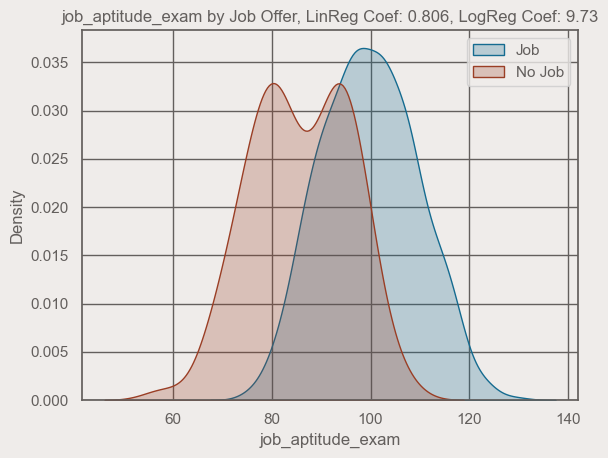

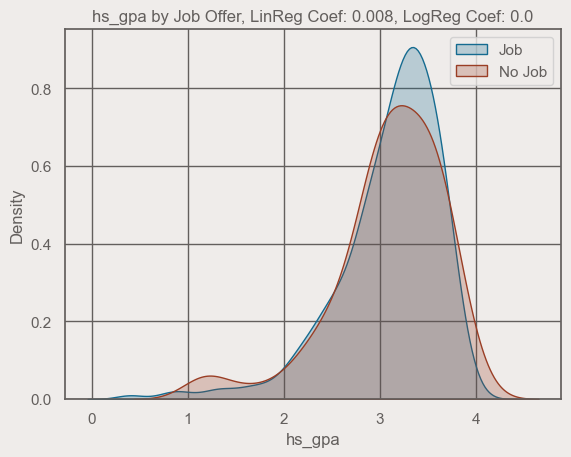

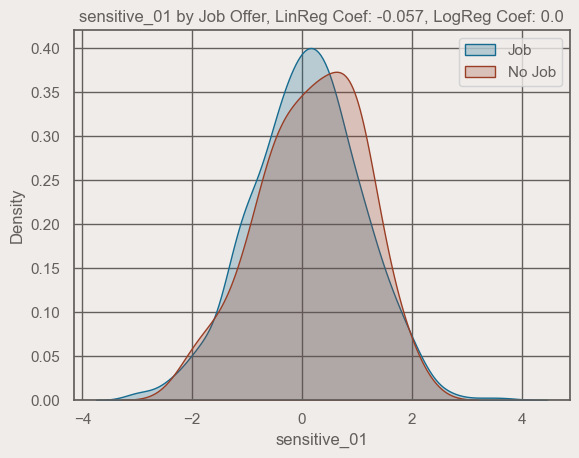

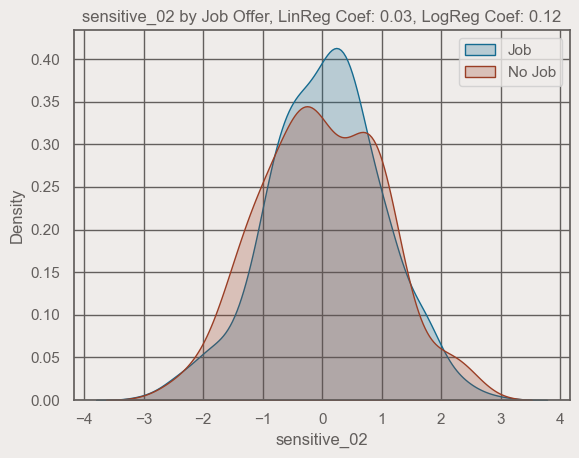

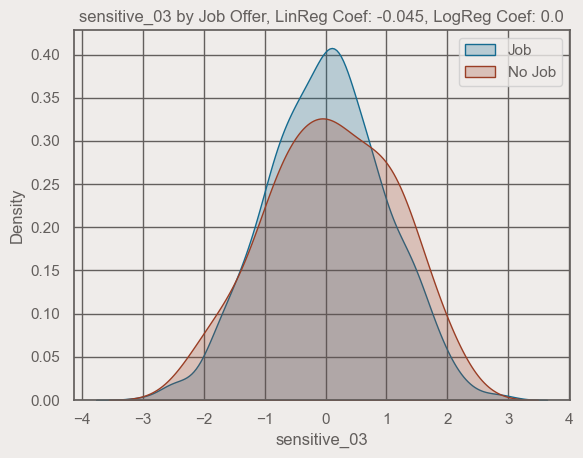

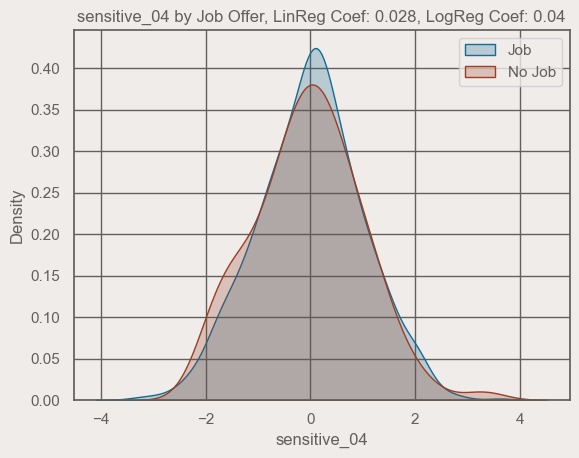

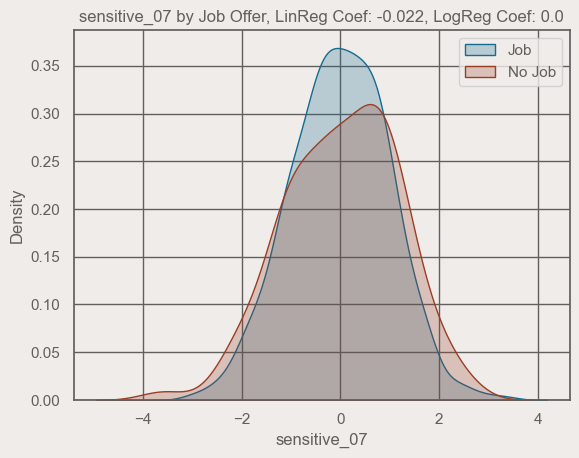

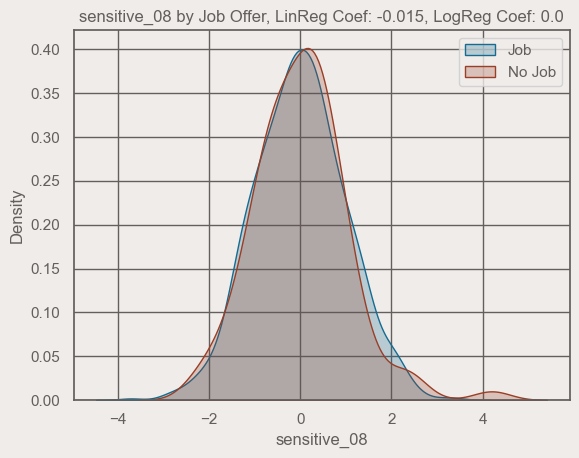

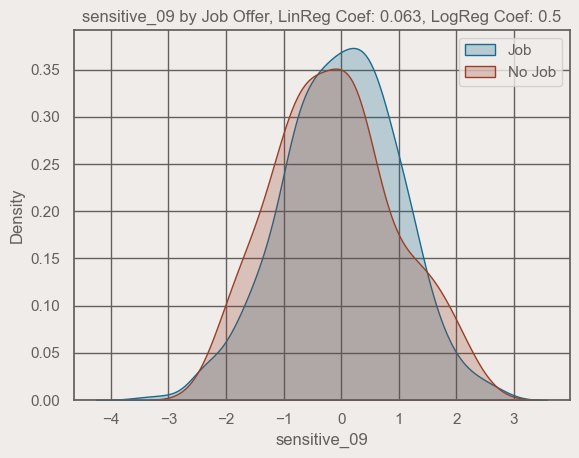

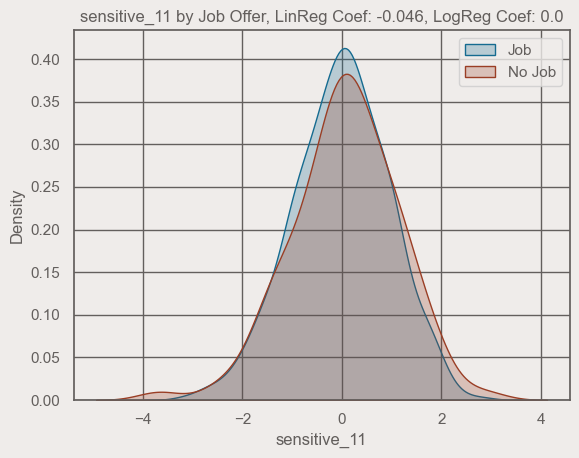

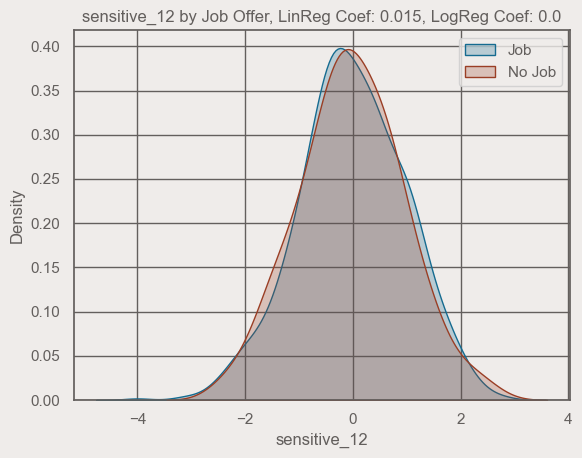

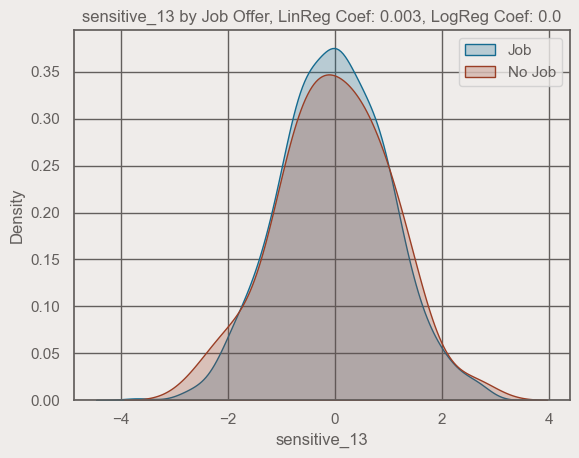

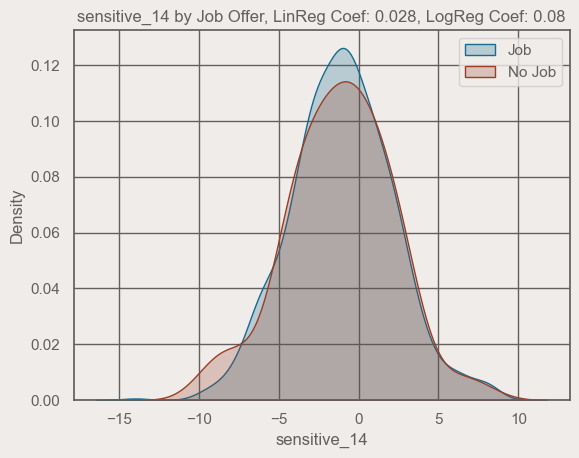

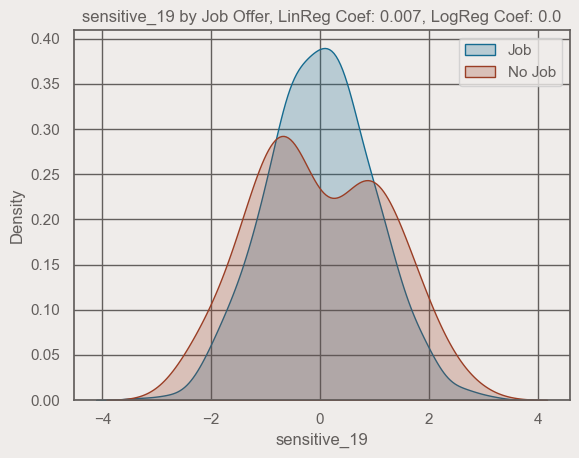

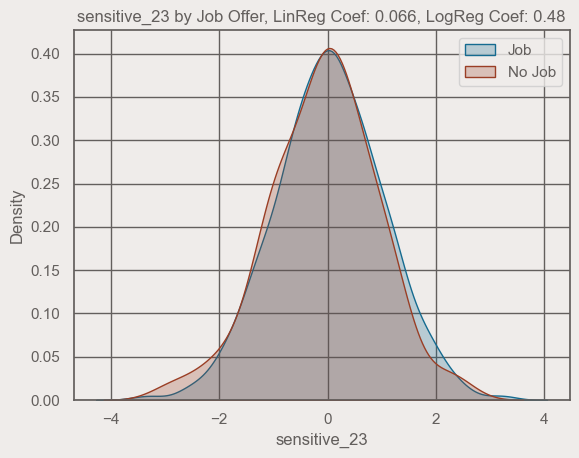

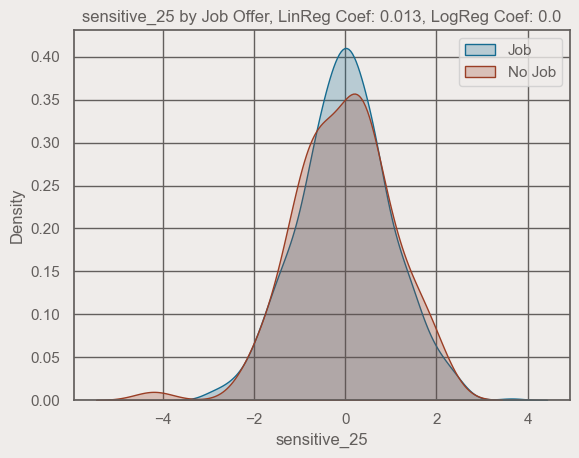

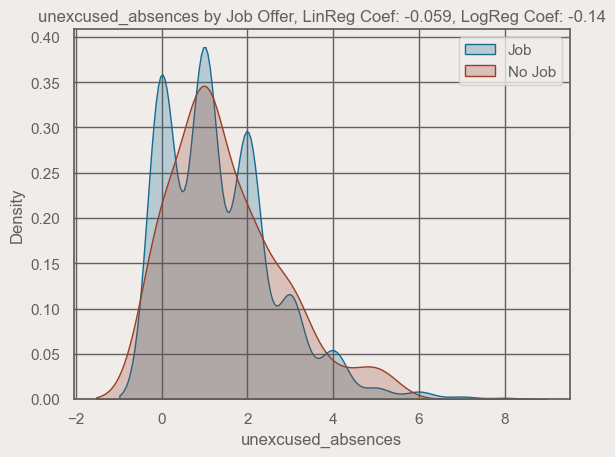

In [11]:
# Let's make some plots to see what features might be good choices

for col,i in zip(float_cols,range(len(float_cols))):
    sns.kdeplot(training_data.loc[training_data['job_offered'] == 1, col], label = 'Job', shade = True)
    sns.kdeplot(training_data.loc[training_data['job_offered'] == 0, col], label = 'No Job', shade = True)
    plt.xlabel(f'{col}'); plt.ylabel('Density'); plt.title(f'{col} by Job Offer, LinReg Coef: {np.round(coef_list[i][0],3)}, LogReg Coef: {np.round(log_coef_list[i][0][0],2)}');plt.legend();plt.show();

In [12]:
# Lots of potential choices! In general, I am looking for features with nonzero coefficients and obvious differences
# in centre / shape of distributions.

# E.g., 'job_aptitude_exam','sensitive_09','sensitive_23', 'unexcused_absences'

In [13]:
# Let's print out some basic statistics about the relationship between the binary variables and the outcome

binary_cols = ['same_industry','enrolled_late', 'good_behavior',
                                        'sensitive_05','sensitive_06','sensitive_10','sensitive_15',
                                        'sensitive_17','sensitive_18','sensitive_20',
                                        'sensitive_22','sensitive_24'];

for cols in binary_cols:
    print(f'{cols} and job_offered Jaccard Similarity:', jaccard_score(training_data.dropna(subset=cols)[cols], training_data.dropna(subset=cols).job_offered))
    print(f'Cases where {cols} and job_offered are similar:', len(training_data.loc[(training_data[cols] == 0) & (training_data.job_offered == 0)]) + len(training_data.loc[(training_data[cols] == 1) & (training_data.job_offered == 1)]))
    print(f'Cases where {cols} and job_offered are dissimilar:', len(training_data.loc[(training_data[cols] == 0) & (training_data.job_offered == 1)]) + len(training_data.loc[(training_data[cols] == 1) & (training_data.job_offered == 0)]))
    print(f'Proportion where {cols} and job_offered are similar:', len(training_data.loc[(training_data[cols] == 0) & (training_data.job_offered == 0)] + training_data.loc[(training_data[cols] == 1) & (training_data.job_offered == 1)]) / len(training_data.dropna(subset=cols).job_offered) )
    print(f'Proportion where {cols} and job_offered are dissimilar:', len(training_data.loc[(training_data[cols] == 0) & (training_data.job_offered == 1)] + training_data.loc[(training_data[cols] == 1) & (training_data.job_offered == 0)]) / len(training_data.dropna(subset=cols).job_offered) )

same_industry and job_offered Jaccard Similarity: 0.022172949002217297
Cases where same_industry and job_offered are similar: 118
Cases where same_industry and job_offered are dissimilar: 882
Proportion where same_industry and job_offered are similar: 0.118
Proportion where same_industry and job_offered are dissimilar: 0.882
enrolled_late and job_offered Jaccard Similarity: 0.013333333333333334
Cases where enrolled_late and job_offered are similar: 112
Cases where enrolled_late and job_offered are dissimilar: 888
Proportion where enrolled_late and job_offered are similar: 0.112
Proportion where enrolled_late and job_offered are dissimilar: 0.888
good_behavior and job_offered Jaccard Similarity: 0.24369747899159663
Cases where good_behavior and job_offered are similar: 270
Cases where good_behavior and job_offered are dissimilar: 630
Proportion where good_behavior and job_offered are similar: 0.3
Proportion where good_behavior and job_offered are dissimilar: 0.7
sensitive_05 and job_off

<Axes: >

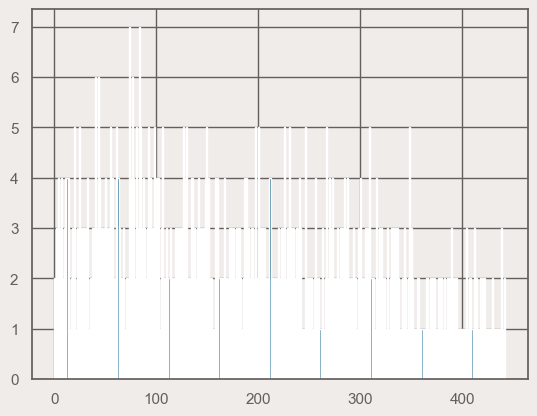

In [14]:
# Last stop, the categorical data -- there are 443 different high schools, so I think I am going to leave this out for now
# With only 1000 rows rows of data, 443 different high schools doesn't make a great feature for fitting

training_data[['high_school','instructor']].high_school.value_counts()

training_data.high_school.hist(bins=range(min(training_data.high_school), max(training_data.high_school) + 1, 1))

In [15]:
# Let's try instructor, instead

training_data[['job_offered','instructor']].instructor.value_counts()

inst_4     181
inst_6     144
inst_5     136
inst_2     121
inst_3     108
inst_7      89
inst_8      69
inst_1      46
inst_9      30
inst_10     12
inst_11      5
inst_0       5
inst_12      3
inst_13      1
Name: instructor, dtype: int64

In [16]:
inst_arr = training_data['instructor'].value_counts().index

for inst in inst_arr:
    print(f'Proportion of 1 for {inst}: {len(training_data.loc[(training_data.job_offered == 1) & (training_data.instructor == inst)].job_offered) / len(training_data.loc[(training_data.instructor == inst)].job_offered)}, Total count: {len(training_data.loc[(training_data.instructor == inst)].job_offered)}')

Proportion of 1 for inst_4: 0.9005524861878453, Total count: 181
Proportion of 1 for inst_6: 0.8958333333333334, Total count: 144
Proportion of 1 for inst_5: 0.9117647058823529, Total count: 136
Proportion of 1 for inst_2: 0.8429752066115702, Total count: 121
Proportion of 1 for inst_3: 0.8888888888888888, Total count: 108
Proportion of 1 for inst_7: 0.9101123595505618, Total count: 89
Proportion of 1 for inst_8: 0.9565217391304348, Total count: 69
Proportion of 1 for inst_1: 0.9565217391304348, Total count: 46
Proportion of 1 for inst_9: 0.8, Total count: 30
Proportion of 1 for inst_10: 1.0, Total count: 12
Proportion of 1 for inst_11: 0.8, Total count: 5
Proportion of 1 for inst_0: 1.0, Total count: 5
Proportion of 1 for inst_12: 1.0, Total count: 3
Proportion of 1 for inst_13: 1.0, Total count: 1


In [17]:
# More similar than I would've thought. Given that there is a pretty large variation in student count per teacher, 
# and they're not that different, will leave them out for now. Could consider including it in a tree model.

In [18]:
# Well, sensisitve_10 is a quite correlated with the outcome in the end, so I might want to consider it
# in a tree model -- similar to instructor.

# Binary features 'sensitive_18','sensitive_22','sensitive_24' are also quite correlated with outcome and NOT missing
# data, so let's start with those.

# Given all of the features and their relationships, I will try a logistic regression, XGBoost, and feed-forward net.

In [19]:
# Define some lists for indexing

fit_float_cols = ['job_aptitude_exam','sensitive_09','sensitive_23'];
fit_int_cols = ['sensitive_18','sensitive_22','sensitive_24'];

In [20]:
df_fit = training_data[['job_aptitude_exam','sensitive_09','sensitive_23','sensitive_18','sensitive_22','sensitive_24','job_offered']]

In [21]:
df_fit_norm = df_fit.copy()

In [22]:
 # Normalize

df_fit_norm[fit_float_cols] = (df_fit[fit_float_cols] - df_fit[fit_float_cols].min()) / (df_fit[fit_float_cols].max() - df_fit[fit_float_cols].min())

# Standardize

df_fit_norm[fit_float_cols] = (df_fit_norm[fit_float_cols] - df_fit_norm[fit_float_cols].mean()) / df_fit_norm[fit_float_cols].std()

In [23]:
# Check correlations

df_fit_norm[['job_aptitude_exam','sensitive_09','sensitive_23']].corr()

,job_aptitude_exam,sensitive_09,sensitive_23
job_aptitude_exam,1.000000,-0.003641,-0.036368
sensitive_09,-0.003641,1.000000,-0.008815
sensitive_23,-0.036368,-0.008815,1.000000


In [24]:
df_fit_norm[['sensitive_18','sensitive_22','sensitive_24']].corr(jaccard_score)

,sensitive_18,sensitive_22,sensitive_24
sensitive_18,1.000000,0.350923,0.359566
sensitive_22,0.350923,1.000000,0.348226
sensitive_24,0.359566,0.348226,1.000000


In [25]:
# The first model I am going to try is a logistic regression using PyMC to handle the inference.
# I set up a Bernoulli problem with a logit link below:

model_coords = ['Intercept','job_aptitude_exam','sensitive_09','sensitive_23','sensitive_18','sensitive_22','sensitive_24'];

with pm.Model(coords = {'coeffs':model_coords}) as logistic_model:

    # Data containers
    # Used for out-of-sample predictions
    jae = pm.MutableData('jae',df_fit_norm.job_aptitude_exam)
    s9 = pm.MutableData('s9',df_fit_norm.sensitive_09)
    s23 = pm.MutableData('s23',df_fit_norm.sensitive_23)
    s18 = pm.MutableData('s18',df_fit_norm.sensitive_18)
    s22 = pm.MutableData('s22',df_fit_norm.sensitive_22)
    s24 = pm.MutableData('s24',df_fit_norm.sensitive_24)
    y = pm.MutableData('y',df_fit_norm.job_offered)

    # Priors
    # Define standard priors for normalize / standardized data
    b_0 = pm.Normal('b_0',mu=0,sigma=1)
    b_jae = pm.Normal('b_jae',mu=0,sigma=1)
    b_s9 = pm.Normal('b_s9',mu=0,sigma=1)
    b_s23 = pm.Normal('b_s23',mu=0,sigma=1)
    b_s18 = pm.Normal('b_s18',mu=0,sigma=1)
    b_s22 = pm.Normal('b_s22',mu=0,sigma=1)
    b_s24 = pm.Normal('b_s24',mu=0,sigma=1)

    # Linear model
    # Set up a linear model with an intercept term
    mu = b_0 + b_jae*jae + b_s9*s9 + b_s23*s23 + b_s18*s18 + b_s22*s22 + b_s24*s24

    # Link function
    p = pm.Deterministic('p', pm.math.invlogit(mu))

    # Likelihood
    pm.Bernoulli('obs', p=p, observed=y, shape=jae.shape)

In [26]:
# Sample using NUTS mcmc

with logistic_model:
    idata = pm.sample(tune = 2000, draws = 2000, chains = 4,
                      nuts_sampler = 'pymc', random_seed=np.random.seed(3332),
                      nuts = {'target_accept':0.95}, idata_kwargs = {'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_jae, b_s9, b_s23, b_s18, b_s22, b_s24]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 100 seconds.


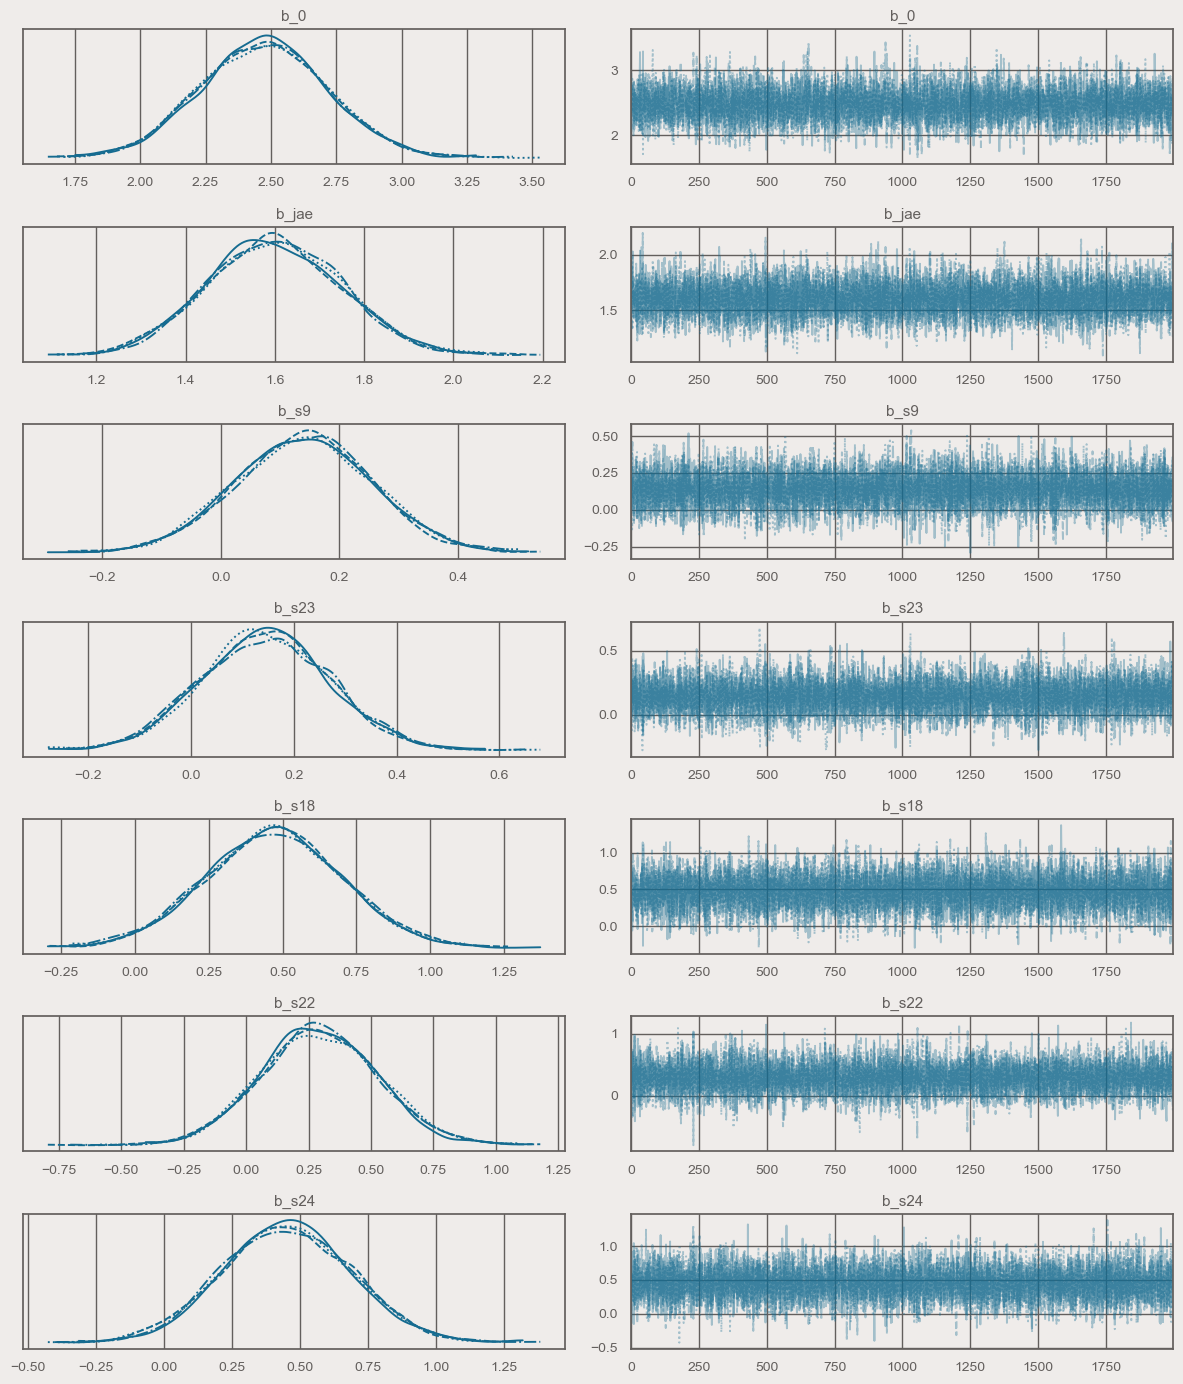

In [27]:
# Check the traces

az.plot_trace(idata, var_names=['b_0','b_jae','b_s9','b_s23','b_s18','b_s22','b_s24'])
plt.tight_layout();

In [28]:
df_score = scoring_data[['job_aptitude_exam','sensitive_09','sensitive_23','sensitive_18','sensitive_22','sensitive_24']]

In [29]:
df_score_norm = df_score.copy()

In [30]:
# Normalize / standardize

df_score_norm[fit_float_cols] = (df_score[fit_float_cols] - df_score[fit_float_cols].min()) / (df_score[fit_float_cols].max() - df_score[fit_float_cols].min())
df_score_norm[fit_float_cols] = (df_score_norm[fit_float_cols] - df_score_norm[fit_float_cols].mean()) / df_score_norm[fit_float_cols].std()

In [31]:
# Pass through new data for prediction

with logistic_model:

    pm.set_data({'jae':df_score_norm.job_aptitude_exam,'s9':df_score_norm.sensitive_09,'s23':df_score_norm.sensitive_23,
                 's18':df_score_norm.sensitive_18,'s22':df_score_norm.sensitive_22,'s24':df_score_norm.sensitive_24})
    
    p_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


In [32]:
# Make prediction with a 1/2 threshold

y_pred = (p_pred.posterior_predictive["obs"].mean(dim=["chain", "draw"]) >= 0.5).astype(int)

In [33]:
# Check to see how many job_offered the model predicted

len(np.where(y_pred.to_numpy() == 1)) / len(np.where(y_pred.to_numpy() == 0) + np.where(y_pred.to_numpy() == 1))

0.5

In [34]:
'''
# Below are checks on diagnostics
# Further diagnostics aren't great either

with logistic_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=np.random.seed(3332))

az.plot_loo_pit(idata,'obs')
plt.show();

az.plot_ppc(idata)
plt.show();

az.summary(idata);
'''

"\n# Below are checks on diagnostics\n# Further diagnostics aren't great either\n\nwith logistic_model:\n    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=np.random.seed(3332))\n\naz.plot_loo_pit(idata,'obs')\nplt.show();\n\naz.plot_ppc(idata)\nplt.show();\n\naz.summary(idata);\n"

In [35]:
# Well, I could've saved myself a bit of time by just flipping a coin!
# Not super surprising, it is potentially a pretty high dimensional problem and the decision boundary is probably nonlinear.

# Let's try an XGBoost.

# Will do two different models, one with the same features as above and one with some features that were missing data.

In [36]:
# Create a dataset for the XGBoost

df_fit_xgb = training_data[['job_aptitude_exam','sensitive_01','sensitive_02','sensitive_09','sensitive_14','sensitive_19','sensitive_23','unexcused_absences',
                            'sensitive_10','sensitive_17','sensitive_18','sensitive_22','sensitive_24',
                            'instructor']]

df_fit_xgb_jo = training_data['job_offered']

fit_float_cols_xgb = ['job_aptitude_exam','sensitive_01','sensitive_02','sensitive_09','sensitive_14','sensitive_19','sensitive_23','unexcused_absences'];

In [37]:
# Replace instructors that had less than 30 students with NaNs, transform it for modelling

df_fit_xgb.instructor = df_fit_xgb.instructor.replace('inst_0',np.nan).replace('inst_10',np.nan).replace('inst_11',np.nan).replace('inst_12',np.nan).replace('inst_13',np.nan).replace('inst_','',regex=True);
df_fit_xgb.instructor = df_fit_xgb.instructor.loc[~df_fit_xgb.instructor.isnull()].astype(int);

C:\Users\camer\AppData\Local\Temp\ipykernel_6124\1315655568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_xgb.instructor = df_fit_xgb.instructor.replace('inst_0',np.nan).replace('inst_10',np.nan).replace('inst_11',np.nan).replace('inst_12',np.nan).replace('inst_13',np.nan).replace('inst_','',regex=True);
C:\Users\camer\AppData\Local\Temp\ipykernel_6124\1315655568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_xgb.instructor = df_fit_xgb.instructor.loc[~df_fit_xgb.instructor.isnull()

In [38]:
df_fit_xgb_norm = df_fit_xgb.copy()

In [39]:
 # Normalize

df_fit_xgb_norm[fit_float_cols_xgb] = (df_fit_xgb[fit_float_cols_xgb] - df_fit_xgb[fit_float_cols_xgb].min()) / (df_fit_xgb[fit_float_cols_xgb].max() - df_fit_xgb[fit_float_cols_xgb].min())

# Standardize

df_fit_xgb_norm[fit_float_cols_xgb] = (df_fit_xgb_norm[fit_float_cols_xgb] - df_fit_xgb_norm[fit_float_cols_xgb].mean()) / df_fit_xgb_norm[fit_float_cols_xgb].std()

In [40]:
# Two sets, the first is the same features from the logistic regression and the second includes more features, some with missing values

x_train, x_test, y_train, y_test = train_test_split(df_fit_xgb_norm[['job_aptitude_exam','sensitive_09','sensitive_23','sensitive_18','sensitive_22','sensitive_24']],df_fit_xgb_jo,
                                                    test_size=0.2, random_state=np.random.seed(3332))

x_train_ext, x_test_ext, y_train_ext, y_test_ext = train_test_split(df_fit_xgb_norm[['job_aptitude_exam','sensitive_09','sensitive_23','sensitive_10','sensitive_18','sensitive_22','sensitive_24','instructor']],df_fit_xgb_jo,
                                                    test_size=0.2, random_state=np.random.seed(3332))

In [41]:
# Fit the models, ensuring to specify the type of model and the evaluation.
# I have also chosen relatively standard hyperparameters that will make the model slightly more conservative
# because of the imbalance (scale_pos_rate, gamma). This will (hopefully) help reduce a high FP rate.

np.random.seed(3332);

xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='auc',learning_rate=0.1,n_estimators=100,
                              gamma=0.5,min_child_weight=2,scale_pos_rate=0.1);
xgb_model_ext = xgb.XGBClassifier(objective='binary:logistic',eval_metric='auc',learning_rate=0.1,n_estimators=100,
                                  gamma=0.5,min_child_weight=2,scale_pos_rate=0.1)

xgb_model.fit(x_train,y_train);
xgb_model_ext.fit(x_train_ext,y_train_ext);

In [42]:
# Make predictions

xgb_pred = xgb_model.predict(x_test)
xgb_pred_ext = xgb_model_ext.predict(x_test_ext)

In [43]:
# Accuracy

print(f'Accuracy of the XGBoost model with the same features as LogReg: {(y_test == xgb_pred).sum() / len(y_test)}') 
print(f'Accuracy of the XGBoost model with extended features: {(y_test == xgb_pred_ext).sum() / len(y_test)}')

Accuracy of the XGBoost model with the same features as LogReg: 0.925
Accuracy of the XGBoost model with extended features: 0.935


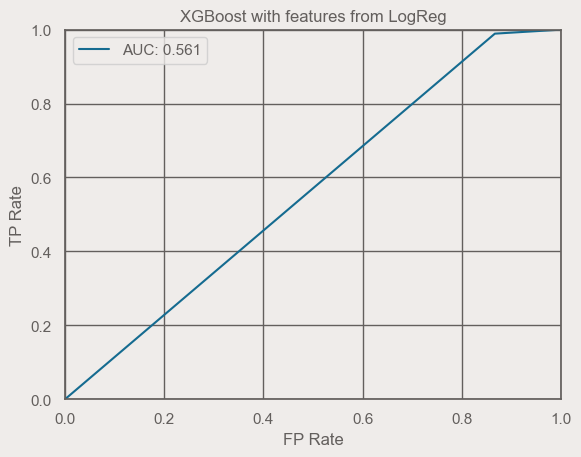

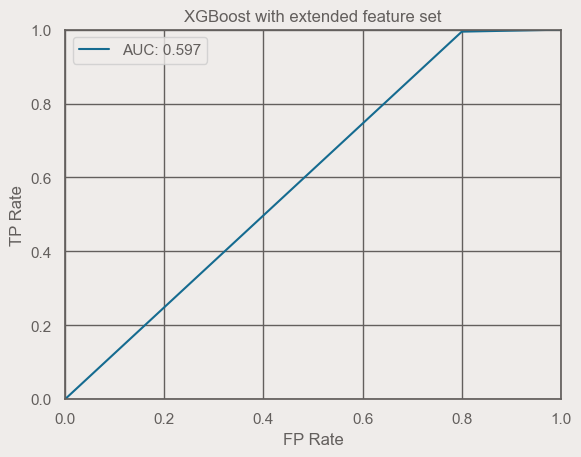

In [44]:
# Plot the ROC Curves

fpr, tpr, threshold = roc_curve(y_test, xgb_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label=f'AUC: {np.round(roc_auc,3)}')
plt.legend();plt.xlim([0,1]);plt.ylim([0,1]);
plt.xlabel('FP Rate');plt.ylabel('TP Rate');
plt.title('XGBoost with features from LogReg');
plt.show();

fpr_ext, tpr_ext, threshold_ext = roc_curve(y_test, xgb_pred_ext)
roc_auc_ext = auc(fpr_ext, tpr_ext)
plt.plot(fpr_ext,tpr_ext,label=f'AUC: {np.round(roc_auc_ext,3)}')
plt.legend();plt.xlim([0,1]);plt.ylim([0,1]);
plt.xlabel('FP Rate');plt.ylabel('TP Rate');
plt.title('XGBoost with extended feature set');
plt.show();

In [45]:
# Check the confusion matrices

tn, fp, fn, tp = confusion_matrix(y_test, xgb_pred).ravel()
tn_ext, fp_ext, fn_ext, tp_ext = confusion_matrix(y_test, xgb_pred_ext).ravel()

# In the following form:
# TP FN
# FP TN

print(f'CM for XGBoost with same features as LogReg: {[[tp,fn],[fp,tn]]}')
print(f'CM for XGBoost with extended feature set: {[[tp_ext,fn_ext],[fp_ext,tn_ext]]}')

CM for XGBoost with same features as LogReg: [[183, 2], [13, 2]]
CM for XGBoost with extended feature set: [[184, 1], [12, 3]]


In [46]:
# Well, it isn't the best classifier I've ever made, but it is an improvement over the logistic regression!
# Results, generally, track with what one would expect. The false positive rate is high, this is pretty standard
# in imbalanced classification tasks and usually requires a nontrivial amount of work to ameliorate.

# Let's try one final model, a feed-forward neural net.

In [47]:
# Putting some functions here for the output

# Helper to format predictions

def format_predictions(predicted):

    assert isinstance(predicted, torch.Tensor)

    predicted = np.asarray([0 if x < 0.5 else 1 for x in predicted])
    
    return predicted

# Helper to plot the score

def plot_scores(train_losses, scores_train, scores_test, score_name, degree=3, window_length=5):
    assert len(scores_train) == len(scores_test) and len(train_losses) == len(scores_train)

    def moving_average(x):
        return np.convolve(x, np.ones(window_length), 'valid') / window_length
    
    train_losses = moving_average(train_losses)
    scores_train = moving_average(scores_train)
    scores_test = moving_average(scores_test)

    x = np.arange(1, len(scores_train) + 1, dtype=np.uint16)
    xnew = np.linspace(x.min(), x.max(), 150)

    new_train_losses = make_interp_spline(x, train_losses, k=degree)(xnew)
    new_scores_train = make_interp_spline(x, scores_train, k=degree)(xnew)
    new_scores_test = make_interp_spline(x, scores_test, k=degree)(xnew)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
    fig.suptitle("Model Performance", fontsize=16)
    for i, ax in enumerate(axs.reshape(-1)):
        if i == 0:
            ax.plot(xnew, new_train_losses, color=sunlight_cat[0], label="Loss")
            ax.set_title("Loss during training")
            ax.legend()
        elif i == 1:
            ax.plot(xnew, new_scores_train, color=sunlight_cat[2], label="{} Fit".format(score_name))
            ax.plot(xnew, new_scores_test, color=sunlight_cat[1], label="{} Test".format(score_name))
            ax.set_title("{} during training".format(score_name))
            ax.legend()

In [48]:
# Fitting function

def fit_net(model, X_train, Y_train, X_test, Y_test, lr=0.001, epochs=1000, batch_size=32, frequency=100):
    
    # Binary classification optimization / scoring
    test_score_function = accuracy_score
    name_score_function = "Accuracy"
    criterion = torch.nn.BCEWithLogitsLoss()
    
    if type(batch_size) != int:
        batch_size = len(X_train)

    def predict(batches, Y):
        with torch.no_grad():
            predictions = []
            for batch in batches:
                predicted = model(batch)
                predicted = format_predictions(predicted=predicted)
                for pred in predicted:
                    predictions.append(pred)
            return test_score_function(Y.detach().numpy(), predictions)

    print("########## STARTED FITTING ##########\n")
    
    # Initiate an optimization method
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Batches
    batches_x_train, batches_y_train = torch.split(X_train, batch_size), torch.split(Y_train, batch_size)
    batches_x_test, batches_y_test = torch.split(X_test, batch_size), torch.split(Y_test, batch_size)

    assert len(batches_x_train) == len(batches_y_train)
    assert len(batches_x_test) == len(batches_y_test)
    
    # Start fit
    loss_train_list, score_train_list, score_test_list = [], [], []
    for epoch in range(epochs):
        # Keep batches in mind
        total_loss = 0.
        for i in range(len(batches_x_train)):
            optimizer.zero_grad() 
            output = model(batches_x_train[i])
            loss = criterion(output, batches_y_train[i])
            total_loss += loss
            loss.backward()
            optimizer.step()
        total_loss = total_loss / len(X_train)
        
        # Save results
        score_train = predict(batches_x_train, Y_train)
        score_test = predict(batches_x_test, Y_test)

        loss_train_list.append(total_loss.item())
        score_train_list.append(score_train.item())
        score_test_list.append(score_test.item())
        
        # Print fit progress
        if epoch % frequency == 0:
            print("[Epoch = {} -> Loss_train: {}, {}_train: {}, {}_test: {}".format(epoch, total_loss, name_score_function, score_train, name_score_function, score_test))

    # Convert back to numpy for ease
    loss_train_list = np.asarray(loss_train_list)
    score_train_list = np.asarray(score_train_list)
    score_test_list = np.asarray(score_test_list)

    # Use the plotting helper
    plot_scores(train_losses=loss_train_list,
                scores_train=score_train_list,
                scores_test=score_test_list,
                score_name=name_score_function)

    print("########## END FITTING ##########\n")

In [49]:
# Feed forward net with fully connected and dropout layers.

# Obviously there is lots more that can be done here, but just putting together 
# something for the application. I figured it might be useful to try after the 
# logistic regression failed so spectacularly, it definitely appears that the 
# decision boundary is nonlinear -- so this should do a better job!

# I have included dropout layers to help avoid overfitting.
# Output from the net is put through a sigmoid because it is 
# supported between [0,1] and we want a single number for the binary classification.

torch.manual_seed(3332);

class FFNN(nn.Module):
    def __init__(self,in_dims,hidden_dims,out_dims,p):
        super(FFNN,self).__init__()

        self.fc1 = nn.Linear(in_dims,hidden_dims)
        self.fc2 = nn.Linear(hidden_dims,hidden_dims)
        self.fc3 = nn.Linear(hidden_dims,hidden_dims)
        self.fc4 = nn.Linear(hidden_dims,out_dims)
        self.dropout = nn.Dropout(torch.tensor(p)) 
        self.float()

    def forward(self,x):
        res = self.fc1(x)
        res = torch.tanh(res)
        res = self.dropout(res)
        res = self.fc2(res)
        res = torch.tanh(res)
        res = self.dropout(res)
        res = self.fc3(res)
        res = torch.tanh(res)
        res = self.dropout(res)
        res = self.fc4(res)
        res = torch.sigmoid(res)
        return torch.squeeze(res)

In [50]:
torch.manual_seed(3332);

ffnn_model = FFNN(in_dims=6,
                  hidden_dims=32, # 32 nodes per layer
                  out_dims=1,
                  p=0.2) # Light dropout

########## STARTED FITTING ##########

[Epoch = 0 -> Loss_train: 0.015992240980267525, Accuracy_train: 0.89375, Accuracy_test: 0.94
[Epoch = 100 -> Loss_train: 0.012510831467807293, Accuracy_train: 0.915, Accuracy_test: 0.94
[Epoch = 200 -> Loss_train: 0.012436139397323132, Accuracy_train: 0.92125, Accuracy_test: 0.945
[Epoch = 300 -> Loss_train: 0.012397871352732182, Accuracy_train: 0.92625, Accuracy_test: 0.935
[Epoch = 400 -> Loss_train: 0.012480364181101322, Accuracy_train: 0.92625, Accuracy_test: 0.925
[Epoch = 500 -> Loss_train: 0.01245064102113247, Accuracy_train: 0.925, Accuracy_test: 0.935
[Epoch = 600 -> Loss_train: 0.012387920171022415, Accuracy_train: 0.92625, Accuracy_test: 0.94
[Epoch = 700 -> Loss_train: 0.012315651401877403, Accuracy_train: 0.92875, Accuracy_test: 0.925
[Epoch = 800 -> Loss_train: 0.01230615098029375, Accuracy_train: 0.93, Accuracy_test: 0.93
[Epoch = 900 -> Loss_train: 0.012261901050806046, Accuracy_train: 0.9325, Accuracy_test: 0.925
########## END FI

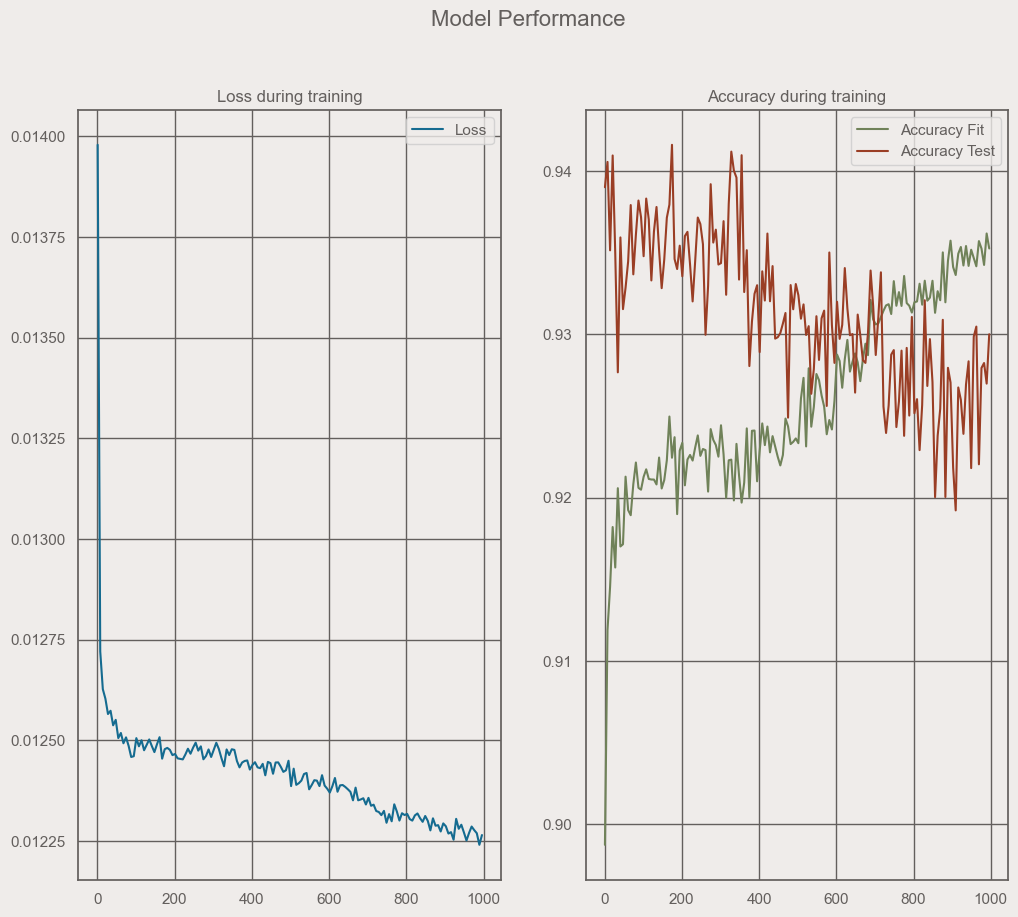

In [51]:
torch.manual_seed(3332);

fit_net(ffnn_model,
        torch.tensor(x_train.values).type(torch.FloatTensor), torch.tensor(y_train.values).type(torch.FloatTensor),
        torch.tensor(x_test.values).type(torch.FloatTensor), torch.tensor(y_test.values).type(torch.FloatTensor),
        lr=0.001,
        epochs=1000,
        batch_size=32, # 25 batches for 800 fitting data
        frequency=100)

In [52]:
# Check scoring sets

df_score_xgb = scoring_data[['job_aptitude_exam','sensitive_09','sensitive_23','sensitive_10','sensitive_18','sensitive_22','sensitive_24','instructor']]

In [53]:
df_score_xgb_norm = df_score_xgb.copy()

In [54]:
 # Normalize

df_score_xgb_norm[fit_float_cols] = (df_fit[fit_float_cols] - df_fit[fit_float_cols].min()) / (df_fit[fit_float_cols].max() - df_fit[fit_float_cols].min())

# Standardize

df_score_xgb_norm[fit_float_cols] = (df_fit_norm[fit_float_cols] - df_fit_norm[fit_float_cols].mean()) / df_fit_norm[fit_float_cols].std()

In [55]:
# Replace instructors that had less than 30 students with NaNs, transform it for scoring

df_score_xgb_norm.instructor = df_score_xgb_norm.instructor.replace('inst_0',np.nan).replace('inst_10',np.nan).replace('inst_11',np.nan).replace('inst_12',np.nan).replace('inst_13',np.nan).replace('inst_','',regex=True);
df_score_xgb_norm.instructor = df_score_xgb_norm.instructor.loc[~df_score_xgb_norm.instructor.isnull()].astype(int);

In [56]:
xgb_score = xgb_model_ext.predict(df_score_xgb_norm)

ffnn_model.eval()
nn_pred = ffnn_model(torch.tensor(df_score_norm.values).type(torch.FloatTensor))

In [57]:
# Proportion of scoring set as job_offered

logreg_proportion = len(np.where(y_pred.to_numpy() == 1)) / len(np.where(y_pred.to_numpy() == 0) + np.where(y_pred.to_numpy() == 1))
xgb_proportion = len(np.where(xgb_score == 1)[0]) / (len(np.where(xgb_score == 0)[0]) + len(np.where(xgb_score == 1)[0]))
ffnn_proportion = len(np.where(nn_pred.type(torch.IntTensor).detach().numpy() == 1)[0]) / (len(np.where(nn_pred.type(torch.IntTensor).detach().numpy() == 0)[0]) + len(np.where(nn_pred.type(torch.IntTensor).detach().numpy() == 1)[0]))

pd.DataFrame({'logistic_regression_proportion':[logreg_proportion],
              'xgboost_proportion':[xgb_proportion],
              'neural_net_proportion':[ffnn_proportion]})

,logistic_regression_proportion,xgboost_proportion,neural_net_proportion
0,0.5,0.991,0.5696


In [58]:
# Assuming that the overall population that participated in the program also had a ~90% success rate,
# none of the models did that well. The XGBoost had a false positive problem, which is reflected in the 
# scoring set proportion above (close to 1). The logistic regression is a coinflip and the neural net
# looks like it has a false negative problem.

# Given time, I would spend quite a bit more time working both on feature selection and parameter choice,
# but I just wanted to demonstrate the above techniques for the application. For example, a significant
# amount of time could be spent with feature engineering transforming and recasting correlated features.
# Further, parameter choice in the XGBoost and neural net have incredibly impactful effects on the outcome,
# and exploring this would likely result in better predictions. It would also be worth time to look at the
# scoring data in a similar manner as I did with the fitting data.

# Thanks again for your time and consideration, I really appreciate it :)